# rerun the script (dint have enough time 13/10)

1
2
3
4


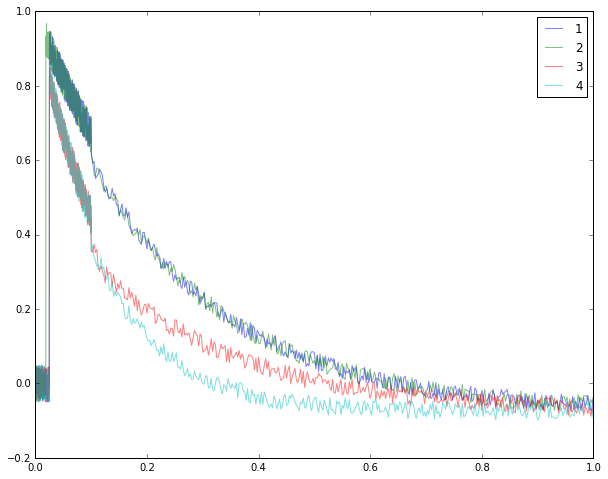

Separation
training label
test label


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3998, 8)           32        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3996, 16)          400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1998, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1998, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31968)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1023008   
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

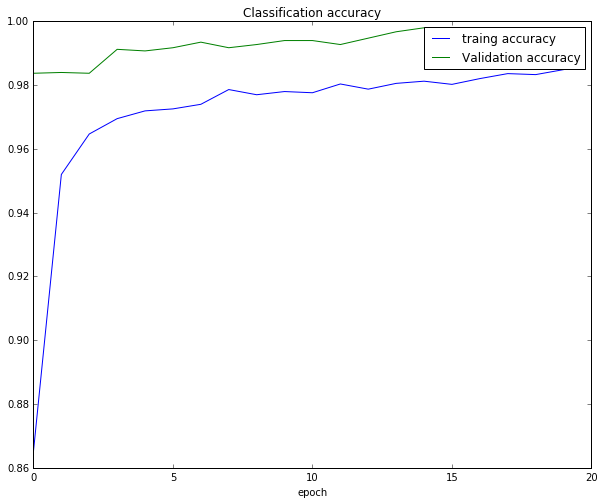

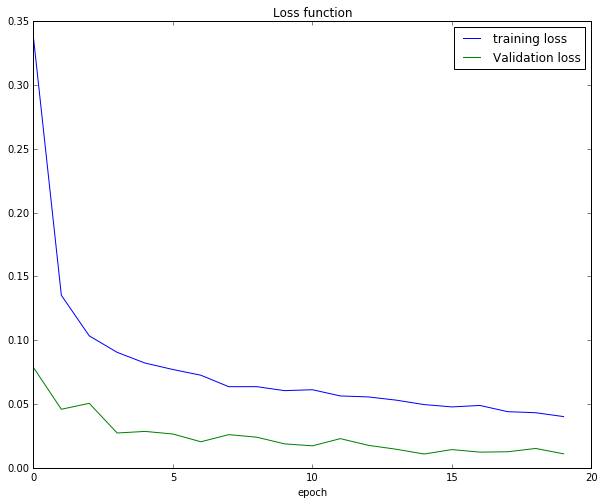

Classification accuracy = 0.997247247635


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0)

noise = 0.1

n = 5000
no_of_x = 4000
Rise_signal = 1

def x_generator(n):
    input_x = np.zeros((n,no_of_x))
    mid = int(n*0.5)
    for i in range(n):
        input_x[i] = np.arange(0,1,0.00025)
    return input_x

x_axis = x_generator(n)

"""Noise manipulator"""

def slowvary(no_of_x,noise):
	z = np.random.rand(int(no_of_x/10.+1.))*noise
	y = np.zeros(no_of_x)
	for i in range(no_of_x):
		y1 = int(i/10.)
		y2 = int(i/10.+1)
		f = z[y2]-z[y1]
		y[i] = z[y1] + f*(i%10)/10.
	return y

def noisegen(x, no_of_x):
    y = np.zeros(no_of_x)
    y1 = no_of_x-400
    y2 = 0.5*x
    test = slowvary(y1,y2)
    for i in range(no_of_x):
        if i <400:
            y[i] = np.random.rand(1)*x - x/2.
        else:
            y[i] = test[i-400]-0.1
    return y

""" functions """

def beta(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y<0.1, y>=0.1], [lambda y:0, lambda y: np.exp(-y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
    return yall

def gamma(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        pileup = np.random.rand(1)*0.4
        y = x[i]*4
        yall[i] = np.piecewise(y, [y < 0.1, y>=0.1 , y >= pileup], [lambda y:0 ,lambda y:0.3*np.exp(-y), lambda y:np.exp(-y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
    return yall

def alt1(x):
    yall = np.zeros((n,no_of_x))
    half = 0.5
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y < 0.1, y>=0.1, y >= half], [lambda y:0 ,lambda y:np.exp(-2*y), lambda y:np.exp(-(y+0.5))])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
    return yall

def alt3(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y<0.1, y>=0.1], [lambda y:0,lambda y:np.exp(-2*y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
    return yall

x1 = beta(x_axis)
print("1")
x2 = gamma(x_axis)
print("2")
x3 = alt1(x_axis)
print("3")
x4 = alt3(x_axis)
print("4")

plt.figure()
plt.plot(x_axis[1],x1[1],label="1",alpha=0.5)
plt.plot(x_axis[1],x2[1],label="2",alpha=0.5)
plt.plot(x_axis[1],x3[1],label="3",alpha=0.5)
plt.plot(x_axis[1],x4[1],label="4",alpha=0.5)
plt.legend()
plt.show()

def separation(x,ratio):
	train = np.zeros((int(len(x)*ratio),no_of_x))
	test = np.zeros((int(len(x)*(1.-ratio)),no_of_x))
	for i in range(n):
		if i < (n*ratio):
			train[i] = x[i]
		if i >= (n*ratio):
			k = i - int(n*ratio) - 1
			test[k] = x[i]
	return train, test

train_beta, test_beta = separation(x1,0.8)
train_gamma, test_gamma  = separation(x2,0.8)
train_3, test_3  = separation(x3,0.8)
train_4, test_4  = separation(x4,0.8)
print("Separation")

def labelling(x,num):
	label = np.zeros(len(x))
	for i in range(len(x)):
		label[i] = num
	return label

label_train_beta = labelling(train_beta,0)
label_train_gamma = labelling(train_gamma,1)
label_train_3 = labelling(train_3,2)
label_train_4 = labelling(train_4,3)
print("training label")

label_test_beta = labelling(test_beta,0)
label_test_gamma = labelling(test_gamma,1)
label_test_3 = labelling(test_3,2)
label_test_4 = labelling(test_4,3)
print("test label")

data_train = np.concatenate((train_beta,train_gamma,train_3,train_4), axis=0)
data_test = np.concatenate((test_beta,test_gamma,test_3,test_4), axis=0)
label_train = np.concatenate((label_train_beta,label_train_gamma,label_train_3,label_train_4),axis=0)
label_test = np.concatenate((label_test_beta,label_test_gamma,label_test_3,label_test_4),axis=0)

data_train = np.expand_dims(data_train,axis=2)
data_test = np.expand_dims(data_test,axis=2)

import keras

classes = 4

label_train = keras.utils.to_categorical(label_train, classes)
label_test = keras.utils.to_categorical(label_test, classes)

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization

from keras.regularizers import l2
from keras.optimizers import SGD

""" Convulution Neural Network """

model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation="relu", input_shape=(no_of_x,1)))
model.add(Conv1D(16, 3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(classes,activation="softmax"))
model.summary()
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics=['accuracy'])
history = model.fit(data_train, label_train, batch_size=50, epochs=20, verbose=1, validation_data=(data_test,label_test))
score = model.evaluate(data_test, label_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="traing accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

# adding 0.1

1
2
3
4


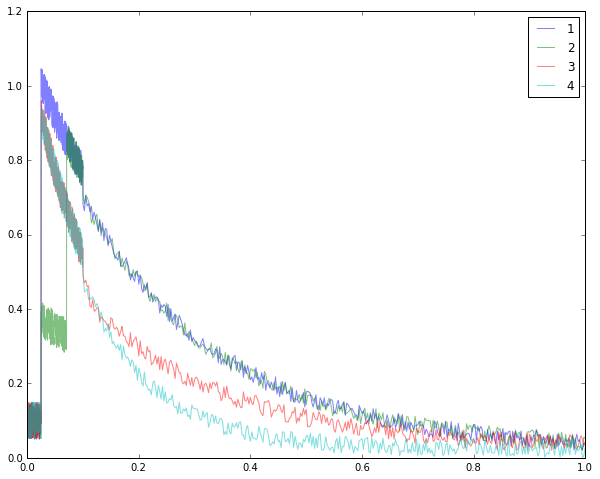

Separation
training label
test label
Test loss: 8.07085621577
Test accuracy: 0.496246246246
Train on 16000 samples, validate on 3996 samples
Epoch 1/30
16000/16000 [==============================] - 54s - loss: 0.5024 - acc: 0.8999 - val_loss: 0.0112 - val_acc: 0.9985
Epoch 2/30
16000/16000 [==============================] - 53s - loss: 0.1023 - acc: 0.9501 - val_loss: 0.0048 - val_acc: 0.9987
Epoch 3/30
16000/16000 [==============================] - 52s - loss: 0.0944 - acc: 0.9542 - val_loss: 0.0073 - val_acc: 0.9982
Epoch 4/30
16000/16000 [==============================] - 53s - loss: 0.0719 - acc: 0.9671 - val_loss: 0.0058 - val_acc: 0.9985
Epoch 5/30
16000/16000 [==============================] - 55s - loss: 0.0650 - acc: 0.9719 - val_loss: 0.0085 - val_acc: 0.9975
Epoch 6/30
16000/16000 [==============================] - 60s - loss: 0.0625 - acc: 0.9722 - val_loss: 0.0047 - val_acc: 0.9985
Epoch 7/30
16000/16000 [==============================] - 54s - loss: 0.0592 - acc: 0.9748 

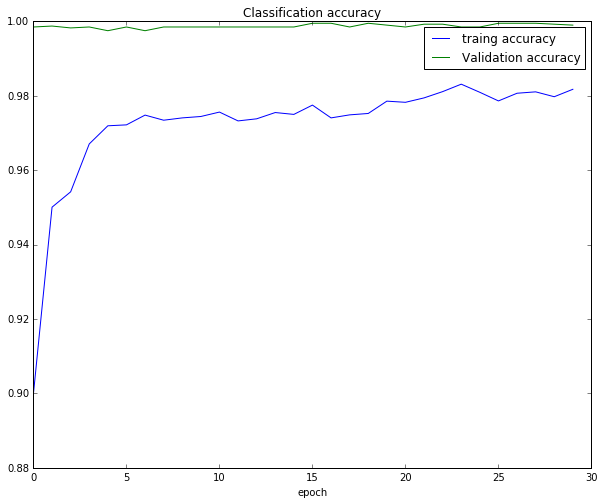

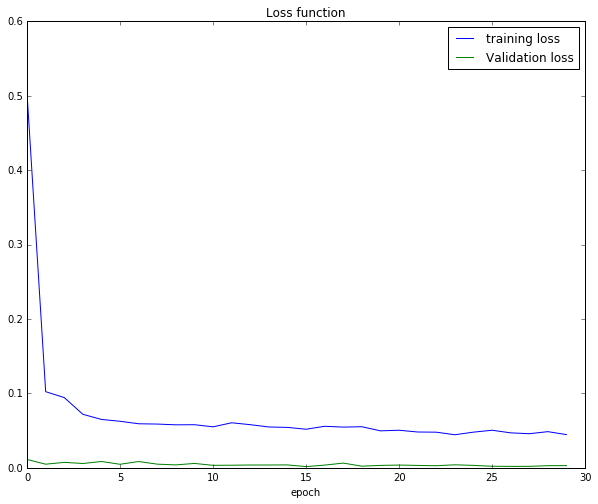

Classification accuracy = 0.998998999954


In [2]:
def ibeta(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y<0.1, y>=0.1], [lambda y:0, lambda y: np.exp(-y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.1 + yall[i]
    return yall

def igamma(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        pileup = np.random.rand(1)*0.4
        y = x[i]*4
        yall[i] = np.piecewise(y, [y < 0.1, y>=0.1 , y >= pileup], [lambda y:0 ,lambda y:0.3*np.exp(-y), lambda y:np.exp(-y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.1 + yall[i]
    return yall

def ialt1(x):
    yall = np.zeros((n,no_of_x))
    half = 0.5
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y < 0.1, y>=0.1, y >= half], [lambda y:0 ,lambda y:np.exp(-2*y), lambda y:np.exp(-(y+0.5))])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.1 + yall[i]
    return yall

def ialt3(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y<0.1, y>=0.1], [lambda y:0,lambda y:np.exp(-2*y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.1 + yall[i]
    return yall

x1 = ibeta(x_axis)
print("1")
x2 = igamma(x_axis)
print("2")
x3 = ialt1(x_axis)
print("3")
x4 = ialt3(x_axis)
print("4")

plt.figure()
plt.plot(x_axis[1],x1[1],label="1",alpha=0.5)
plt.plot(x_axis[1],x2[1],label="2",alpha=0.5)
plt.plot(x_axis[1],x3[1],label="3",alpha=0.5)
plt.plot(x_axis[1],x4[1],label="4",alpha=0.5)
plt.legend()
plt.show()

train_beta, test_beta = separation(x1,0.8)
train_gamma, test_gamma  = separation(x2,0.8)
train_3, test_3  = separation(x3,0.8)
train_4, test_4  = separation(x4,0.8)
print("Separation")

label_train_beta = labelling(train_beta,0)
label_train_gamma = labelling(train_gamma,1)
label_train_3 = labelling(train_3,2)
label_train_4 = labelling(train_4,3)
print("training label")

label_test_beta = labelling(test_beta,0)
label_test_gamma = labelling(test_gamma,1)
label_test_3 = labelling(test_3,2)
label_test_4 = labelling(test_4,3)
print("test label")

data_train = np.concatenate((train_beta,train_gamma,train_3,train_4), axis=0)
data_test = np.concatenate((test_beta,test_gamma,test_3,test_4), axis=0)
label_train = np.concatenate((label_train_beta,label_train_gamma,label_train_3,label_train_4),axis=0)
label_test = np.concatenate((label_test_beta,label_test_gamma,label_test_3,label_test_4),axis=0)

data_train = np.expand_dims(data_train,axis=2)
data_test = np.expand_dims(data_test,axis=2)

label_train = keras.utils.to_categorical(label_train, classes)
label_test = keras.utils.to_categorical(label_test, classes)

score = model.evaluate(data_test, label_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

history = model.fit(data_train, label_train, batch_size=50, epochs=30, verbose=1, validation_data=(data_test,label_test))
score = model.evaluate(data_test, label_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="traing accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])

# adding more

1
2
3
4


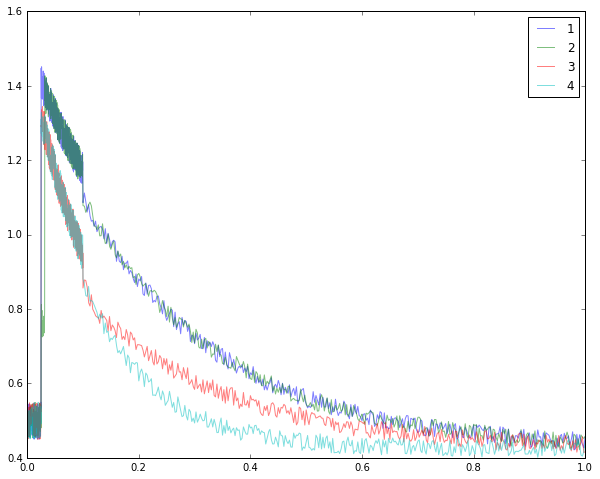

Separation
training label
test label
Test loss: 8.06967292351
Test accuracy: 0.496996996997
Train on 16000 samples, validate on 3996 samples
Epoch 1/30
16000/16000 [==============================] - 37s - loss: 1.0974 - acc: 0.6833 - val_loss: 0.1730 - val_acc: 0.9950
Epoch 2/30
16000/16000 [==============================] - 35s - loss: 0.4572 - acc: 0.7220 - val_loss: 0.2094 - val_acc: 0.9952
Epoch 3/30
16000/16000 [==============================] - 35s - loss: 0.4030 - acc: 0.7604 - val_loss: 0.1197 - val_acc: 0.9970
Epoch 4/30
16000/16000 [==============================] - 35s - loss: 0.3732 - acc: 0.8138 - val_loss: 0.1009 - val_acc: 0.9950
Epoch 5/30
16000/16000 [==============================] - 36s - loss: 0.3452 - acc: 0.9031 - val_loss: 0.1080 - val_acc: 0.9970
Epoch 6/30
16000/16000 [==============================] - 35s - loss: 0.3266 - acc: 0.9187 - val_loss: 0.0764 - val_acc: 0.9950
Epoch 7/30
16000/16000 [==============================] - 36s - loss: 0.3077 - acc: 0.9232 

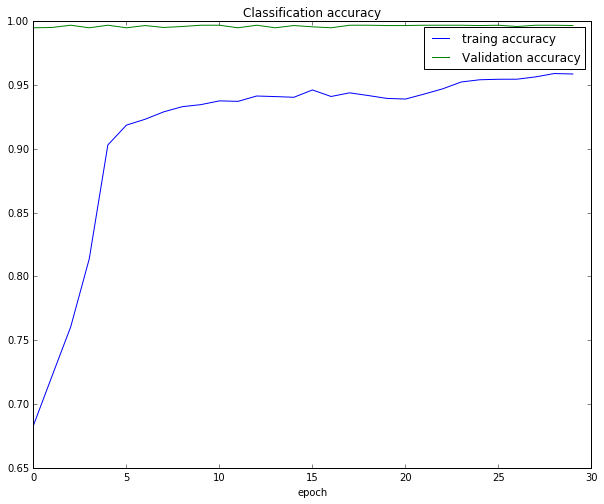

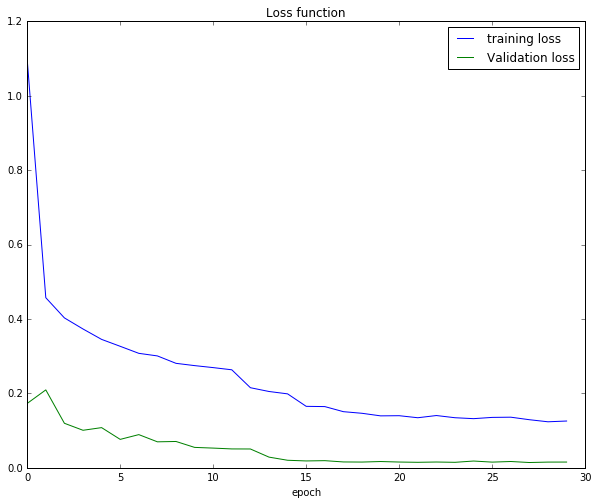

Classification accuracy = 0.996746747612


In [3]:
def ibeta(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y<0.1, y>=0.1], [lambda y:0, lambda y: np.exp(-y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.5 + yall[i]
    return yall

def igamma(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        pileup = np.random.rand(1)*0.4
        y = x[i]*4
        yall[i] = np.piecewise(y, [y < 0.1, y>=0.1 , y >= pileup], [lambda y:0 ,lambda y:0.3*np.exp(-y), lambda y:np.exp(-y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.5 + yall[i]
    return yall

def ialt1(x):
    yall = np.zeros((n,no_of_x))
    half = 0.5
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y < 0.1, y>=0.1, y >= half], [lambda y:0 ,lambda y:np.exp(-2*y), lambda y:np.exp(-(y+0.5))])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.5 + yall[i]
    return yall

def ialt3(x):
    yall = np.zeros((n,no_of_x))
    for i in range(n):
        y = x[i]*4
        yall[i] = np.piecewise(y, [y<0.1, y>=0.1], [lambda y:0,lambda y:np.exp(-2*y)])
        yall[i] = yall[i] + noisegen(noise,no_of_x)
        yall[i] = 0.5 + yall[i]
    return yall

x1 = ibeta(x_axis)
print("1")
x2 = igamma(x_axis)
print("2")
x3 = ialt1(x_axis)
print("3")
x4 = ialt3(x_axis)
print("4")

plt.figure()
plt.plot(x_axis[1],x1[1],label="1",alpha=0.5)
plt.plot(x_axis[1],x2[1],label="2",alpha=0.5)
plt.plot(x_axis[1],x3[1],label="3",alpha=0.5)
plt.plot(x_axis[1],x4[1],label="4",alpha=0.5)
plt.legend()
plt.show()

train_beta, test_beta = separation(x1,0.8)
train_gamma, test_gamma  = separation(x2,0.8)
train_3, test_3  = separation(x3,0.8)
train_4, test_4  = separation(x4,0.8)
print("Separation")

label_train_beta = labelling(train_beta,0)
label_train_gamma = labelling(train_gamma,1)
label_train_3 = labelling(train_3,2)
label_train_4 = labelling(train_4,3)
print("training label")

label_test_beta = labelling(test_beta,0)
label_test_gamma = labelling(test_gamma,1)
label_test_3 = labelling(test_3,2)
label_test_4 = labelling(test_4,3)
print("test label")

data_train = np.concatenate((train_beta,train_gamma,train_3,train_4), axis=0)
data_test = np.concatenate((test_beta,test_gamma,test_3,test_4), axis=0)
label_train = np.concatenate((label_train_beta,label_train_gamma,label_train_3,label_train_4),axis=0)
label_test = np.concatenate((label_test_beta,label_test_gamma,label_test_3,label_test_4),axis=0)

data_train = np.expand_dims(data_train,axis=2)
data_test = np.expand_dims(data_test,axis=2)

label_train = keras.utils.to_categorical(label_train, classes)
label_test = keras.utils.to_categorical(label_test, classes)

score = model.evaluate(data_test, label_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

history = model.fit(data_train, label_train, batch_size=50, epochs=30, verbose=1, validation_data=(data_test,label_test))
score = model.evaluate(data_test, label_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="traing accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])